Hypothesis: Lora updates are more likely to get permuted with respect to each other
Setting: Train a small Lora model (all linear) on MNIST

In [ ]:
import torch
import torch.nn as nn
from peft import LoraConfig, get_peft_model, PeftModel
import numpy as np
from typing import Tuple, Dict
from copy import deepcopy
from lmc.utils.setup_training import seed_everything

from lmc.permutations import PermSpec, create_permspec_from_model

%load_ext autoreload
%autoreload 2


In [2]:
device = torch.device("cpu")

if torch.backends.mps.is_available():
    # device = torch.device("mps")
    pass
elif torch.cuda.is_available():
    device = torch.device("cuda")

print(f"Using device: {device}")

Using device: mps


In [3]:
import torchvision
import torchvision.transforms as transforms

def setup_mnist_loader(batch_size=32, train=True, seed=None):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))  # MNIST mean and std
    ])
    
    dataset = torchvision.datasets.MNIST(
        root='./data', 
        train=train,
        download=True,
        transform=transform
    )
    
    # Set generator for reproducible shuffling if seed is provided
    generator = torch.Generator()
    if seed is not None:
        generator.manual_seed(seed)
    
    loader = torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=train,
        generator=generator if seed is not None else None
    )
    
    return loader

In [4]:

def create_test_model(in_dim=10, out_dim=10, hidden_dim=20, num_hidden_layers=3, add_norm=False):
    """Create a simple test model with multiple layers"""
    layers = []
    for _ in range(num_hidden_layers):
        layers.append(nn.Linear(in_dim, hidden_dim))
        in_dim = hidden_dim
        if add_norm:
            layers.append(nn.LayerNorm(hidden_dim))
        layers.append(nn.ReLU())
    layers.append(nn.Linear(hidden_dim, out_dim))
    model = nn.Sequential(*layers)
    model.to(device)
    return model
    
def get_lora_model(config, base_model):
    
    # Configure LoRA
    lora_config = LoraConfig(
        r=config.lora.r,
        lora_alpha=config.lora.lora_alpha,
        target_modules=config.lora.target_modules,  
        lora_dropout=config.lora.lora_dropout,
        bias=config.lora.bias,
    )
    
    # Create LoRA model
    model_with_lora = get_peft_model(deepcopy(base_model), lora_config)
    model_with_lora.to(device)
    return model_with_lora

def train_lora(config, base_model=None, lora_model=None):
    if base_model is None:
        base_model = create_test_model(config.model.in_dim, config.model.out_dim, config.model.hidden_dim, config.model.num_hidden_layers, config.model.add_norm)
    if lora_model is None:
        lora_model = get_lora_model(config, base_model)
    
    # Setup training
    train_loader = setup_mnist_loader(batch_size=config.data.batch_size, train=True, seed=config.data.seed)
    optimizer = torch.optim.Adam(lora_model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    
    # Training loop
    for epoch in range(config.train.epochs):
        for x, y in train_loader:
            x = x.to(device)
            y = y.to(device)
            
            optimizer.zero_grad()
            output = lora_model(x.flatten(1))
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            
        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")
    
    return base_model, lora_model

In [5]:
def get_weights(base_model: torch.nn.Module, lora_model: PeftModel) -> Tuple[Dict[str, torch.Tensor], Dict[str, torch.Tensor]]:
    base_weights = {}
    lora_weights = {}
    
    for name, module in base_model.named_modules():
        if isinstance(module, torch.nn.Linear):
            base_weights[name] = module.weight.detach().clone()
    
    for name, module in lora_model.named_modules():
        if hasattr(module, 'active_adapter') and hasattr(module, 'get_base_layer'):
            base_layer = module.get_base_layer()
            if isinstance(base_layer, torch.nn.Linear):
                merged_weight = base_layer.weight.clone()
                
                if (a := module.active_adapter) is not None:
                    a = a[0]
                    lora_A = module.lora_A[a].weight
                    lora_B = module.lora_B[a].weight
                    scaling = module.scaling[a]
                    
                    lora_contribution = (lora_B @ lora_A) * scaling
                    merged_weight += lora_contribution
                
                name = name.replace("base_model.model.", "")
                lora_weights[name] = merged_weight.detach()
    return base_weights, lora_weights

In [6]:
from ml_collections import ConfigDict

config = ConfigDict()
config.model = ConfigDict()
config.model.in_dim = 784
config.model.out_dim = 10
config.model.hidden_dim = 2000
config.model.num_hidden_layers = 1
config.model.add_norm = False

config.data = ConfigDict()
config.data.batch_size = 32
config.data.dim = config.model.in_dim

config.lora = ConfigDict()
config.lora.r = 30
config.lora.lora_alpha = 16
config.lora.target_modules = [f"{2*i}" for i in range(config.model.num_hidden_layers+1)] # Target first and last linear layers
config.lora.lora_dropout = 0.
config.lora.bias = "none"

config.train = ConfigDict()
config.train.epochs = 10
config.seed1 = 42
config.seed2 = 43
config.data.seed = 42



In [7]:
print("Training first model")
seed_everything(config.seed1)
config.data.seed = 42
base_model = create_test_model(config.model.in_dim, config.model.out_dim, config.model.hidden_dim, config.model.num_hidden_layers, config.model.add_norm)
seed_everything(config.seed1)
lora_model = get_lora_model(config, base_model)
seed_everything(config.seed1)
lora_model2 = get_lora_model(config, base_model)

for (n1, m1), (n2, m2) in zip(lora_model.named_parameters(), lora_model2.named_parameters()):
    print(n1, torch.allclose(m1, m2), m1.device)

Training first model
base_model.model.0.base_layer.weight True mps:0
base_model.model.0.base_layer.bias True mps:0
base_model.model.0.lora_A.default.weight True mps:0
base_model.model.0.lora_B.default.weight True mps:0
base_model.model.2.base_layer.weight True mps:0
base_model.model.2.base_layer.bias True mps:0
base_model.model.2.lora_A.default.weight True mps:0
base_model.model.2.lora_B.default.weight True mps:0


In [8]:
print("Training first model")
seed_everything(config.seed1)
config.data.seed = 42
base_model = create_test_model(config.model.in_dim, config.model.out_dim, config.model.hidden_dim, config.model.num_hidden_layers, config.model.add_norm)
lora_model = get_lora_model(config, base_model)
lora_model2 = deepcopy(lora_model)

base_model, lora_model = train_lora(config, base_model, lora_model)

print("Training second model")
config.data.seed = 43
base_model, lora_model2 = train_lora(config, base_model, lora_model2)


base_weights, lora_weights = get_weights(base_model, lora_model)
base_weights, lora_weights2 = get_weights(base_model, lora_model2)

print(base_weights.keys())
print(lora_weights.keys())


: 

In [35]:
from lmc.permutations import weight_matching, is_identity_perm, all_perms_are_identity, get_fixed_points_ratio

from lmc.permutations import PermSpec, create_permspec_from_model

base_weights, lora_weights = get_weights(base_model, lora_model)
base_weights, lora_weights2 = get_weights(base_model, lora_model2)

ps = create_permspec_from_model(base_model)
print(ps)

wm = weight_matching(ps, base_weights, lora_weights)
print(f"Base-Lora: {all_perms_are_identity(wm)} with {get_fixed_points_ratio(wm)} fixed points")

wm = weight_matching(ps, base_weights, lora_weights2)
print(f"Base-Lora2: {all_perms_are_identity(wm)} with {get_fixed_points_ratio(wm)} fixed points")

wm = weight_matching(ps, lora_weights, lora_weights2)
print(f"Lora-Lora2: {all_perms_are_identity(wm)} with {get_fixed_points_ratio(wm)} fixed points")



   None Permutations    
┏━━━━━━┳━━━━━━━┳━━━━━━━┓
┃ P_in ┃ Param ┃ P_out ┃
┡━━━━━━╇━━━━━━━╇━━━━━━━┩
│      │ 0     │ P_0   │
│ P_0  │ 2     │       │
└──────┴───────┴───────┘

Base-Lora: True with 1.0 fixed points
Base-Lora2: True with 1.0 fixed points
Lora-Lora2: False with 0.724 fixed points


Quick experiment above shows that Loras will get permuted wrt each other. Now let's simulate this with respect to hidden dim of the base model and hidden dim of the loras.

Training 0th trial for hidden_dim=500, lora_rank=8, num_hidden_layers=1
Epoch 5, Loss: 0.0897
Epoch 10, Loss: 0.0783
Epoch 5, Loss: 0.1225
Epoch 10, Loss: 0.2400
Training 0th trial for hidden_dim=500, lora_rank=16, num_hidden_layers=1
Epoch 5, Loss: 0.0494
Epoch 10, Loss: 0.0453
Epoch 5, Loss: 0.0851
Epoch 10, Loss: 0.1932
Training 0th trial for hidden_dim=500, lora_rank=32, num_hidden_layers=1
Epoch 5, Loss: 0.1345
Epoch 10, Loss: 0.0487
Epoch 5, Loss: 0.0571
Epoch 10, Loss: 0.1057
Training 0th trial for hidden_dim=1000, lora_rank=8, num_hidden_layers=1
Epoch 5, Loss: 0.0672
Epoch 10, Loss: 0.0463
Epoch 5, Loss: 0.1144
Epoch 10, Loss: 0.2290
Training 0th trial for hidden_dim=1000, lora_rank=16, num_hidden_layers=1
Epoch 5, Loss: 0.0702
Epoch 10, Loss: 0.0802
Epoch 5, Loss: 0.0558
Epoch 10, Loss: 0.1401
Training 0th trial for hidden_dim=1000, lora_rank=32, num_hidden_layers=1
Epoch 5, Loss: 0.0237
Epoch 10, Loss: 0.0112
Epoch 5, Loss: 0.0224
Epoch 10, Loss: 0.1406
Training 0th trial fo

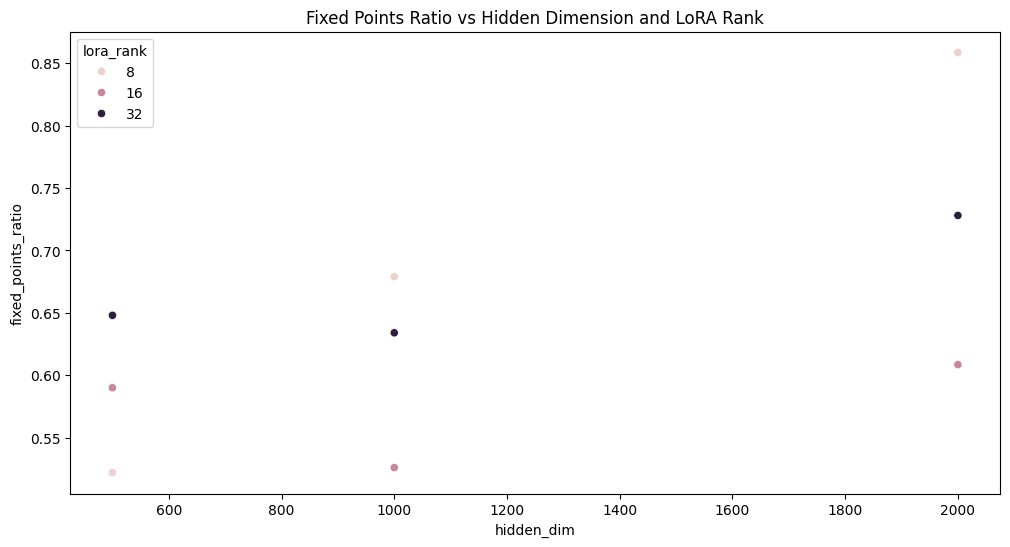


Summary of permutation behavior:
                     fixed_points_ratio     is_identity
                                   mean std        mean
hidden_dim lora_rank                                   
500        8                      0.522 NaN         0.0
           16                     0.590 NaN         0.0
           32                     0.648 NaN         0.0
1000       8                      0.679 NaN         0.0
           16                     0.526 NaN         0.0
           32                     0.634 NaN         0.0
2000       8                      0.858 NaN         0.0
           16                     0.608 NaN         0.0
           32                     0.728 NaN         0.0


In [36]:
import pandas as pd

def analyze_lora_permutations(
    hidden_dims=[500, 1000, 2000], 
    lora_ranks=[8, 16, 32], 
    num_trials=3,
    num_hidden_layers=[1]
):
    """Analyze permutation behavior of LoRA models with different dimensions.
    
    Args:
        hidden_dims: List of hidden dimensions to test for base model
        lora_ranks: List of LoRA ranks to test
        num_trials: Number of trials per configuration
        num_hidden_layers: Number of hidden layers in the model
    
    Returns:
        results: Dict containing permutation analysis results
    """
    results = {
        'hidden_dim': [],
        'lora_rank': [],
        'trial': [],
        'fixed_points_ratio': [],
        'is_identity': [],
        'num_hidden_layers': []
    }
    
    for hidden_dim in hidden_dims:
        for rank in lora_ranks:
            for hidden_layers in num_hidden_layers:
                for trial in range(num_trials):
                    print(f"Training {trial}th trial for hidden_dim={hidden_dim}, lora_rank={rank}, num_hidden_layers={hidden_layers}")
                    # Update config
                    config.model.hidden_dim = hidden_dim
                    config.model.num_hidden_layers = hidden_layers
                    config.lora.r = rank
                    
                    seed_everything(config.seed1)
                    base_model = create_test_model(config.model.in_dim, config.model.out_dim, config.model.hidden_dim, config.model.num_hidden_layers, config.model.add_norm)
                    seed_everything(config.seed1)
                    lora_model = get_lora_model(config, base_model)
                    seed_everything(config.seed1)
                    lora_model2 = get_lora_model(config, base_model)
                    # Train two LoRA models
                    seed_everything(config.seed1)
                    config.data.seed = 42 + trial*151
                    print("Training first model")
                    base_model, lora_model1 = train_lora(config, base_model, lora_model)
                    config.data.seed = 43 + trial*151
                    print("Training second model")
                    _, lora_model2 = train_lora(config, base_model, lora_model2)
                    
                    # Get weights and analyze permutations
                    base_weights, lora_weights1 = get_weights(base_model, lora_model1)
                    _, lora_weights2 = get_weights(base_model, lora_model2)
                    
                    ps = create_permspec_from_model(base_model)
                    wm = weight_matching(ps, lora_weights1, lora_weights2)
                    print(f"Lora1-Lora2: with {get_fixed_points_ratio(wm)} fixed points")
                    print("="*100)
                    
                    # Store results
                    results['hidden_dim'].append(hidden_dim)
                    results['lora_rank'].append(rank)
                    results['num_hidden_layers'].append(hidden_layers)
                    results['trial'].append(trial)
                    results['fixed_points_ratio'].append(get_fixed_points_ratio(wm))
                    results['is_identity'].append(all_perms_are_identity(wm))
    
    return pd.DataFrame(results)

# Run analysis
hidden_dims = [128, 512, 1024, 2048]
lora_ranks = [8, 16, 32, 512]
num_hidden_layers = [1]
num_trials = 1
results_df = analyze_lora_permutations(hidden_dims, lora_ranks, num_trials, num_hidden_layers)

# Plot results
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.scatterplot(data=results_df, x='hidden_dim', y='fixed_points_ratio', hue='lora_rank')
plt.title('Fixed Points Ratio vs Hidden Dimension and LoRA Rank')
plt.show()

# Print summary statistics
print("\nSummary of permutation behavior:")
summary = results_df.groupby(['hidden_dim', 'lora_rank']).agg({
    'fixed_points_ratio': ['mean', 'std'],
    'is_identity': 'mean'
}).round(3)
print(summary)

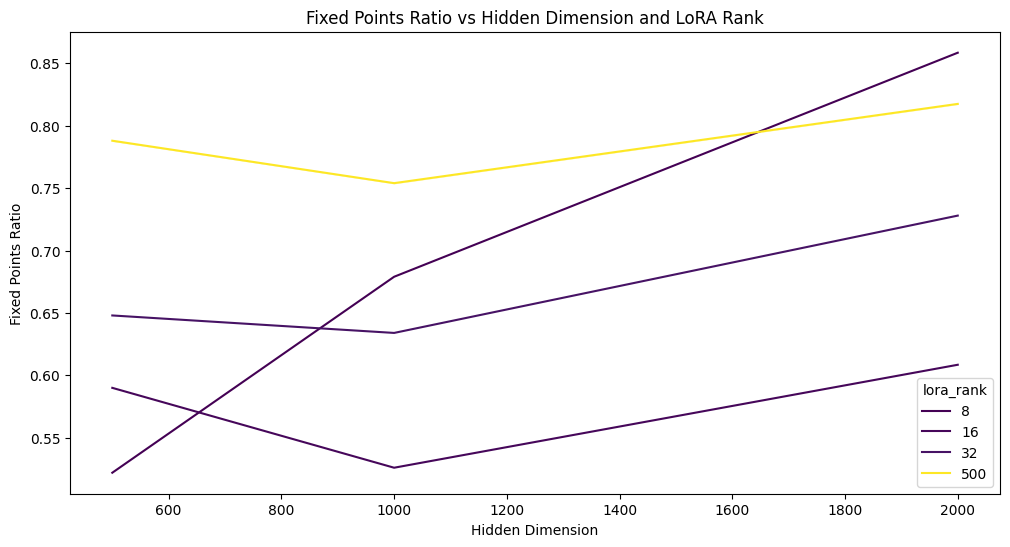

In [51]:

plt.figure(figsize=(12, 6))
sns.lineplot(data=results_df, x='hidden_dim', y='fixed_points_ratio', hue='lora_rank', palette='viridis')
plt.title('Fixed Points Ratio vs Hidden Dimension and LoRA Rank')
plt.xlabel('Hidden Dimension')
plt.ylabel('Fixed Points Ratio')
plt.savefig('lora_permutations.pdf', dpi=300)
plt.show()



Okay but what is the significance? Does alignment improve connectivity?
Do we want LORAs to be LMC?

In [49]:
results_df = pd.concat([results_df, results_df1])